In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Loading dataset...
Dataset loaded in 40.48s
Train samples: 50000, Test samples: 10000
ViT WITH FIXED QAT IMPLEMENTATION
Model parameters: 4,019,466
Starting training...
Epoch [10/250], Loss: 1.4405, Acc: 58.05%, Best: 58.05%
Epoch [20/250], Loss: 1.2095, Acc: 68.43%, Best: 68.43%
Epoch [30/250], Loss: 1.0253, Acc: 75.67%, Best: 75.67%
Epoch [40/250], Loss: 0.9162, Acc: 77.94%, Best: 78.04%
Epoch [50/250], Loss: 0.8357, Acc: 78.56%, Best: 79.84%
Epoch [60/250], Loss: 0.7785, Acc: 80.04%, Best: 81.00%
Epoch [70/250], Loss: 0.7258, Acc: 80.46%, Best: 81.43%
Epoch [80/250], Loss: 0.6852, Acc: 79.75%, Best: 81.53%
Epoch [90/250], Loss: 0.6500, Acc: 80.36%, Best: 81.53%
Epoch [100/250], Loss: 0.6230, Acc: 80.83%, Best: 81.53%
Epoch [110/250], Loss: 0.6027, Acc: 80.89%, Best: 81.53%
Epoch [120/250], Loss: 0.5826, Acc: 81.54%, Best: 81.81%
Epoch [130/250], Loss: 0.5722, Acc: 81.90%, Best: 81.90%
Epoch [140/250], Loss: 0.5574, Acc: 81.80%, Best: 81.95%
Epoch [150/250], Loss: 

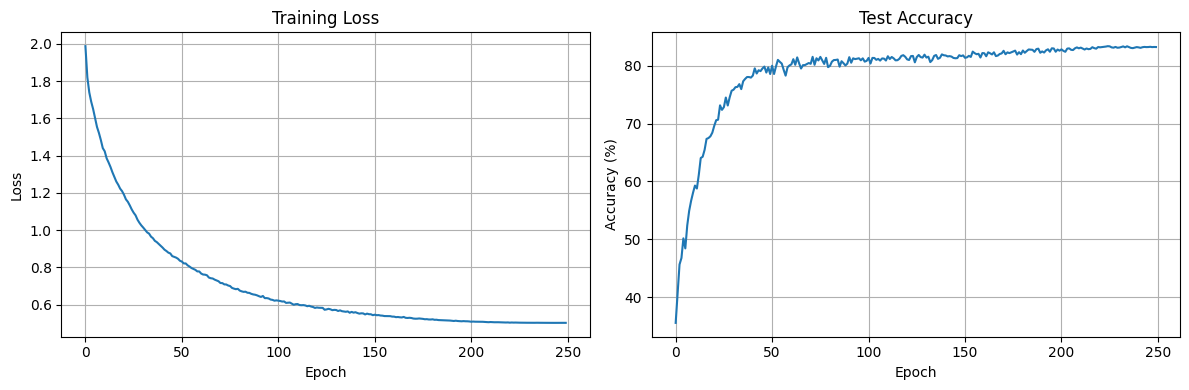


Applying QAT (Accuracy: 83.37% > 70%)
Preparing model for QAT...
Starting QAT fine-tuning...
QAT Epoch [1/10], Loss: 0.0832
QAT Epoch [2/10], Loss: 0.0556
QAT Epoch [3/10], Loss: 0.0432
QAT Epoch [4/10], Loss: 0.0335
QAT Epoch [5/10], Loss: 0.0298
QAT Epoch [6/10], Loss: 0.0298
QAT Epoch [7/10], Loss: 0.0212
QAT Epoch [8/10], Loss: 0.0265
QAT Epoch [9/10], Loss: 0.0227
QAT Epoch [10/10], Loss: 0.0191
Converting to quantized model...


RuntimeError: getCudnnDataTypeFromScalarType() not supported for QUInt8

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub, prepare_qat, convert
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
import time
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration for optimal performance
class Config:
    # Hardware settings
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Model architecture (optimized for speed and accuracy)
    img_size = 64
    patch_size = 8
    embed_dim = 256
    depth = 6
    num_heads = 8
    mlp_ratio = 3.0
    
    # Training settings
    batch_size = 128
    num_epochs = 250
    initial_lr = 0.001
    weight_decay = 0.05
    
    # QAT settings - FIXED CONFIG
    qat_epochs = 10
    qat_lr = 1e-4
    
    # Data settings
    num_workers = 4
    pin_memory = True

config = Config()
print(f"Using device: {config.device}")

# Data paths
base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-32"

# Data augmentation
train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4, padding_mode='reflect'),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

def create_dataframe(split):
    """Create DataFrame with image paths and labels"""
    data = []
    split_path = os.path.join(base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                data.append([img_path, class_name])
    
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
start_time = time.time()

train_df = create_dataframe("train")
test_df = create_dataframe("test")

# Encode labels
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])

print(f"Dataset loaded in {time.time() - start_time:.2f}s")
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except:
            # Return black image for corrupted files
            image = torch.zeros(3, config.img_size, config.img_size)
            label = self.labels[idx]
            return image, label

# Create datasets
train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size, 
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.batch_size, 
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

# FIXED ViT MODEL FOR QAT
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * config.mlp_ratio)
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class OptimizedViT(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=3.0, dropout=0.1):
        super().__init__()
        
        # Quantization stubs - MUST BE AT BEGINNING/END
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        # Position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Quantize input
        x = self.quant(x)
        
        # Patch embedding
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        
        # Dequantize output
        x = self.dequant(x)
        return x

def train_model(model, train_loader, test_loader, config):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.initial_lr, weight_decay=config.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    
    scaler = GradScaler()
    best_acc = 0.0
    train_losses, test_accs = [], []
    
    print("Starting training...")
    
    for epoch in range(config.num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100. * correct / total
        avg_loss = train_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'accuracy': test_acc,
                'epoch': epoch
            }, 'best_model.pth')
        
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{config.num_epochs}], Loss: {avg_loss:.4f}, Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    print(f'Best Accuracy: {best_acc:.2f}%')
    return train_losses, test_accs, best_acc

# FIXED QAT FUNCTION
def prepare_model_for_qat(model):
    """Prepare model for QAT with proper configuration"""
    model.train()
    
    # FIXED: Use per_tensor quantization instead of per_channel
    model.qconfig = torch.quantization.QConfig(
        activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8),
        weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8)
    )
    
    # Prepare for QAT
    model_prepared = prepare_qat(model, inplace=False)
    return model_prepared

def apply_qat(model, train_loader, config):
    """Apply Quantization-Aware Training"""
    print("Preparing model for QAT...")
    
    # Prepare model
    model_qat = prepare_model_for_qat(model)
    model_qat = model_qat.to(config.device)
    
    # QAT training
    optimizer = torch.optim.Adam(model_qat.parameters(), lr=config.qat_lr)
    criterion = nn.CrossEntropyLoss()
    
    print("Starting QAT fine-tuning...")
    
    for epoch in range(config.qat_epochs):
        model_qat.train()
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            if i > 20:  # Use only 20 batches for speed
                break
                
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad()
            outputs = model_qat(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'QAT Epoch [{epoch+1}/{config.qat_epochs}], Loss: {running_loss/20:.4f}')
    
    # Convert to quantized model
    print("Converting to quantized model...")
    model_qat.eval()
    model_quantized = convert(model_qat, inplace=False)
    
    return model_quantized

# Main execution
if __name__ == "__main__":
    print("="*50)
    print("ViT WITH FIXED QAT IMPLEMENTATION")
    print("="*50)
    
    # Create and train model
    model = OptimizedViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        mlp_ratio=config.mlp_ratio,
        num_classes=len(le.classes_)
    ).to(config.device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    # Train the model
    train_losses, test_accs, best_acc = train_model(model, train_loader, test_loader, config)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()
    
    # Apply QAT if accuracy is good
    if best_acc > 70.0:
        print(f"\nApplying QAT (Accuracy: {best_acc:.2f}% > 70%)")
        
        # Load best model
        checkpoint = torch.load('best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Apply QAT
        quantized_model = apply_qat(model, train_loader, config)
        
        # Test quantized model
        quantized_model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = quantized_model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        qat_acc = 100. * correct / total
        
        # Save quantized model
        torch.save(quantized_model.state_dict(), 'quantized_model.pth')
        
        # Model size comparison
        original_size = sum(p.numel() * 4 for p in model.parameters()) / 1024 / 1024
        quantized_size = sum(p.numel() * p.element_size() for p in quantized_model.parameters()) / 1024 / 1024
        
        print(f"\n=== QAT RESULTS ===")
        print(f"Original accuracy: {best_acc:.2f}%")
        print(f"Quantized accuracy: {qat_acc:.2f}%")
        print(f"Accuracy drop: {best_acc - qat_acc:.2f}%")
        print(f"Original size: {original_size:.2f} MB")
        print(f"Quantized size: {quantized_size:.2f} MB")
        print(f"Size reduction: {(1 - quantized_size/original_size)*100:.1f}%")
        
    else:
        print(f"\nSkipping QAT (Accuracy: {best_acc:.2f}% <= 70%)")
    
    print("\nTraining completed successfully!")

In [ ]:
# quant_export.py
import os, json, math
import torch, numpy as np
from torchvision import transforms, datasets
from PIL import Image

# ---- CONFIG ----
MODEL_CHECKPOINT = "best_model.pth"  
OUT_DIR = "export_mem"
NUM_BITS = 8  # target bits for weights (int8)
ACT_BITS = 8  # activations int8
CALIBRATION_SAMPLES = 128  # for activation calibration if doing PTQ
DEVICE = torch.device("cpu")  # we'll run quantized model on CPU
# -----------------

os.makedirs(OUT_DIR, exist_ok=True)

def write_hex_mem(filename, arr, signed=True, width_bytes=1):
    """
    arr: 1D numpy array of ints (signed expected if signed=True).
    width_bytes: 1 for int8, 4 for int32 bias, etc.
    Writes hex per-line (little-endian not necessary for readmemh).
    """
    with open(filename, "w") as f:
        for v in arr.flatten():
            if signed:
                # produce two's complement unsigned representation
                bits = width_bytes * 8
                u = int(v) & ((1 << bits) - 1)
            else:
                u = int(v)
            f.write(f"{u:0{width_bytes*2}x}\n")

def quantize_np_symmetric(tensor_np, num_bits=8):
    """Symmetric per-tensor quantization: returns int np array and scale"""
    max_abs = float(np.max(np.abs(tensor_np))) if tensor_np.size else 0.0
    if max_abs == 0:
        scale = 1.0
    else:
        qmax = 2**(num_bits-1) - 1
        scale = max_abs / qmax
    q = np.round(tensor_np / scale).astype(np.int32)
    qmin = -2**(num_bits-1)
    qmax = 2**(num_bits-1)-1
    q = np.clip(q, qmin, qmax).astype(np.int8 if num_bits==8 else np.int16)
    return q, float(scale)

# --- helper: load checkpoint state_dict or quantized state ---
ckpt = torch.load(MODEL_CHECKPOINT, map_location='cpu')
# ckpt may be dict with 'model_state_dict' or just state_dict
if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
    state_dict = ckpt['model_state_dict']
else:
    state_dict = ckpt

# Try to detect if this is a quantized model object (we'll later try both ways)
# We'll implement two flows: (A) if you have model object quantized_model (recommended),
# (B) if you only have state_dict (float), we quantize offline per-tensor.

print("Export folder:", OUT_DIR)

# ---------- FLOW A: If you already have a quantized model object ----------
# If you have `quantized_model` in memory (after convert()), use this block:
def export_from_quantized_model(model_quantized, out_dir=OUT_DIR):
    """
    Extracts packed quantized weights from a quantized PyTorch model (modules like
    nnq.Linear / nnq.Conv2d) and writes .mem + metadata.
    """
    meta = {}
    model_quantized.to(DEVICE)
    model_quantized.eval()
    for name, module in model_quantized.named_modules():
        # Many quantized modules expose .weight() which is a Quantized Tensor
        try:
            # handle quantized layers like torch.ao.nn.quantized.Linear/Conv2d
            if hasattr(module, 'weight') and callable(module.weight):
                qweight = module.weight()  # quantized tensor
                # int repr and scale/zero_point
                w_int = qweight.int_repr().cpu().numpy().astype(np.int8)
                scale = float(qweight.q_scale())
                zp = int(qweight.q_zero_point())
                fname = f"{name.replace('.', '_')}_weight.mem"
                write_hex_mem(os.path.join(out_dir, fname), w_int, signed=True, width_bytes=1)
                meta[name + ".weight"] = {"file": fname, "shape": list(w_int.shape), "scale": scale, "zero_point": zp, "dtype":"int8"}
            # bias could be attribute
            if hasattr(module, 'bias') and module.bias is not None:
                b = module.bias
                # bias in quantized modules might already be float or int32 depending on config
                if isinstance(b, torch.Tensor):
                    b_np = b.detach().cpu().numpy()
                    fname = f"{name.replace('.', '_')}_bias.mem"
                    # write as signed 32-bit hex
                    write_hex_mem(os.path.join(out_dir, fname), b_np.astype(np.int32), signed=True, width_bytes=4)
                    meta[name + ".bias"] = {"file": fname, "shape": list(b_np.shape), "dtype":"int32"}
        except Exception:
            # fallback: some layers expose ._weight_bias or state_dict entries; skip silently
            continue

    # Save metadata
    with open(os.path.join(out_dir, "export_meta_quant.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print("Exported quantized model weights to", out_dir)
    return meta

# ---------- FLOW B: If you only have float state_dict ----------
def export_from_state_dict(state_dict, out_dir=OUT_DIR, num_bits=NUM_BITS):
    meta = {}
    for key, tensor in state_dict.items():
        arr = tensor.cpu().numpy().astype(np.float32)
        # Quantize per-tensor symmetric int8
        q_arr, scale = quantize_np_symmetric(arr, num_bits=num_bits)
        fname = f"{key.replace('.', '_')}.mem"
        write_hex_mem(os.path.join(out_dir, fname), q_arr, signed=True, width_bytes=1)
        meta[key] = {"file": fname, "shape": list(arr.shape), "scale": scale, "dtype":"int8"}
    # save meta
    with open(os.path.join(out_dir, "export_meta_ptq.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print("Exported PTQ quantized weights to", out_dir)
    return meta

# ---------- Export an example input image (quantized) ----------
def export_input_image_mem(img_path=None, out_dir=OUT_DIR, act_bits=ACT_BITS, test_transform=None):
    # If no image provided, use first image from CIFAR10 test set (deterministic)
    if img_path is None:
        # load CIFAR test (will download if needed)
        ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
        img_tensor, label = ds[0]  # first sample
        img_np = img_tensor.numpy().astype(np.float32)
    else:
        img = Image.open(img_path).convert("RGB")
        if test_transform is None:
            raise ValueError("Provide test_transform or img_path=None for CIFAR auto")
        img_tensor = test_transform(img)
        img_np = img_tensor.numpy().astype(np.float32)

    # quantize per-tensor
    q_img, s = quantize_np_symmetric(img_np, num_bits=act_bits)
    fname = "input_image.mem"
    write_hex_mem(os.path.join(out_dir, fname), q_img, signed=True, width_bytes=1)
    meta = {"file": fname, "shape": list(q_img.shape), "scale": s, "dtype":"int8"}
    with open(os.path.join(out_dir, "input_meta.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print("Exported input image to", os.path.join(out_dir, fname))
    return meta

# ---------- Utility: test quantized model on CPU ----------
def test_quantized_model_on_cpu(model_quantized, test_loader):
    model_quantized.to('cpu')
    model_quantized.eval()
    correct, total = 0, 0
    for images, labels in test_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')
        with torch.no_grad():
            outputs = model_quantized(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100.0 * correct / total
    print(f"Quantized model accuracy on CPU: {acc:.2f}%")
    return acc

# ---------------- Main decide-and-run ----------------
# If user has quantized model object in memory (quantized_model), use that:
if 'quantized_model' in globals():
    print("Detected quantized_model in memory — exporting from quantized object.")
    meta = export_from_quantized_model(globals()['quantized_model'], OUT_DIR)
    _ = export_input_image_mem(None, OUT_DIR, act_bits=ACT_BITS, test_transform=test_transform)
else:
    # If only state_dict available, export PTQ per-tensor
    print("No quantized_model in memory. Exporting from state_dict using PTQ per-tensor quantization.")
    meta = export_from_state_dict(state_dict, OUT_DIR, num_bits=NUM_BITS)
    _ = export_input_image_mem(None, OUT_DIR, act_bits=ACT_BITS, test_transform=test_transform)

print("Done. Files in:", OUT_DIR)